In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import scanpy as sc
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [6]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/mnt/ldata/Sadegh/my_codes/spFlux')

## Read flux and TMA preprocessed Data

### Read Metabolic Task data

In [7]:
metabolic_task_df = pd.read_csv(parent_dir / 'data/scCellFie/scCellFie_metabolic_tasks_with_name.csv', low_memory=False)
metabolic_task_df.rename(columns={'Unnamed: 0':'cell'},inplace=True)
metabolic_task_df.head()

,cell,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,...,Tyrosine to adrenaline,Tyrosine to dopamine,Uridine triphosphate synthesis (UTP),Valine degradation,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation
0,58_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,191_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,193_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print("count of +inf:", np.isposinf(metabolic_task_df.iloc[:,1:].to_numpy()).sum())
print("count of -inf:", np.isneginf(metabolic_task_df.iloc[:,1:].to_numpy()).sum())

count of +inf: 0
count of -inf: 12


In [9]:
metabolic_task_df = metabolic_task_df.replace(-np.inf, 0)

### Read Reactions data

In [10]:
reactions_df = pd.read_csv(parent_dir / 'data/scCellFie/scCellFie_reactions_with_name.csv', low_memory=False)
reactions_df.rename(columns={'Unnamed: 0':'cell'},inplace=True)
reactions_df.head()

,cell,3HLYTCL,5HLTDL,ACCOAC,ACCOACm,AG13T10g,AG13T11g,AG13T12g,AG13T13g,AG13T14g,...,co_TRANSLOC_6,co_TRANSLOC_7,post_TRANSLOC_1,post_TRANSLOC_2,post_TRANSLOC_3B_1,post_TRANSLOC_3B_2,post_TRANSLOC_3B_3,r0173,r0773,retro_TRANSLOC_1
0,58_1_TMA1_minimal,NaN,NaN,0.0,-25.286903,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.656899,NaN,0.0
1,63_1_TMA1_minimal,NaN,NaN,0.0,-22.940934,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090263,NaN,0.0
2,87_1_TMA1_minimal,2.126593,2.126593,0.0,9.054779,0.643387,0.643387,0.643387,0.643387,0.643387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.473437,0.904772,0.0
3,191_1_TMA1_minimal,NaN,NaN,0.0,8.378964,0.655214,0.655214,0.655214,0.655214,0.655214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.108381,0.762824,0.0
4,193_1_TMA1_minimal,NaN,NaN,0.0,-1.363394,0.682846,0.682846,0.682846,0.682846,0.682846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.191072,1.023960,0.0


In [11]:
print("count of +inf:", np.isposinf(reactions_df.iloc[:,1:].to_numpy()).sum())
print("count of -inf:", np.isneginf(reactions_df.iloc[:,1:].to_numpy()).sum())

count of +inf: 0
count of -inf: 316876


In [12]:
reactions_df = reactions_df.replace(-np.inf, 0)

### Read selected gene expression data

In [13]:
gene_df = pd.read_csv(parent_dir / 'data/scCellFie/scCellFie_genes_with_name.csv', low_memory=False)
gene_df.rename(columns={'Unnamed: 0':'cell'},inplace=True)
gene_df.head()

,cell,ACACB,ARF1,ARG1,ATP5F1E,B3GNT7,CALM1,CYP1B1,CYP2U1,DDC,...,HSP90B1,IDO1,KYNU,LDHA,PTGS1,PTGS2,SEC61G,ST6GAL1,TP53,TYMS
0,58_1_TMA1_minimal,-3.522289,7.893295,-0.223461,1.053089,-2.727221,20.691909,-4.763867,-4.401147,-7.549863,...,13.720060,-3.004225,-5.387278,6.034732,-4.345392,-1.010720,-14.830749,-5.358715,11.716334,-9.210989
1,63_1_TMA1_minimal,-3.508786,5.813170,-2.763541,-0.085549,-0.339110,7.252323,-4.144313,32.357548,-7.547486,...,-1.074493,19.061523,-1.440986,0.197274,-3.780262,-3.907242,-14.079218,-6.351712,-8.852268,-7.756938
2,87_1_TMA1_minimal,18.136441,4.033157,-2.392831,0.948675,22.993376,-8.208049,-3.588381,-3.315162,15.884180,...,-13.579868,-4.490324,-4.057965,5.036203,25.181430,-0.897421,-8.557185,11.860245,-6.510208,5.960089
3,191_1_TMA1_minimal,15.395354,8.423885,-2.329424,0.719245,24.102954,9.592794,-3.493294,-0.936705,-3.568303,...,4.421025,-4.371337,-3.950435,9.015220,-3.186431,-1.705948,5.554974,12.468108,9.490307,-5.532739
4,193_1_TMA1_minimal,-0.846022,8.367492,-2.866343,5.598248,26.887122,7.656998,-2.465111,0.363966,-6.496070,...,-16.363039,-3.942734,-3.539174,9.654103,-1.926728,-4.052589,-13.006790,-6.041210,-9.626650,10.078787


In [14]:
print("count of +inf:", np.isposinf(gene_df.iloc[:,1:].to_numpy()).sum())
print("count of -inf:", np.isneginf(gene_df.iloc[:,1:].to_numpy()).sum())

count of +inf: 0
count of -inf: 0


### Read adata data

In [16]:
adata = sc.read(parent_dir / 'data/h5ad/merged_TMA_processed_compatible.h5ad')
adata

AnnData object with n_obs × n_vars = 242061 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [17]:
cols = ["Treatment_Status", "Subject_ID", "sample" ]

obs_df = adata.obs[cols].copy()
obs_df = adata.obs[cols].reset_index().rename(columns={"index": "cell"})
obs_df

,cell,Treatment_Status,Subject_ID,sample
0,58_1_TMA1_minimal,Treated,89397,TMA1_minimal
1,63_1_TMA1_minimal,Treated,89397,TMA1_minimal
2,87_1_TMA1_minimal,Treated,89397,TMA1_minimal
3,191_1_TMA1_minimal,Treated,89397,TMA1_minimal
4,193_1_TMA1_minimal,Treated,89397,TMA1_minimal
...,...,...,...,...
242056,398_417_TMA4_minimal,Untreated,1228762B,TMA4_minimal
242057,405_417_TMA4_minimal,Untreated,1228762B,TMA4_minimal
242058,411_417_TMA4_minimal,Untreated,1228762B,TMA4_minimal
242059,418_417_TMA4_minimal,Untreated,1228762B,TMA4_minimal


### Merge datasets

In [18]:
# merged_df = metabolic_task_df.merge(obs_df, on="cell", how="inner") \
#                .merge(reactions_df, on="cell", how="inner") \
#                .merge(gene_df, on="cell", how="inner")

# merged_df = gene_df.merge(obs_df, on="cell", how="inner") \
#                .merge(reactions_df, on="cell", how="inner")

merged_df = metabolic_task_df.merge(obs_df, on="cell", how="inner")
merged_df

,cell,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,...,Valine degradation,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,Treatment_Status,Subject_ID,sample
0,58_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,TMA1_minimal
1,63_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,TMA1_minimal
2,87_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,TMA1_minimal
3,191_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,TMA1_minimal
4,193_1_TMA1_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,TMA1_minimal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242056,398_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,TMA4_minimal
242057,405_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,TMA4_minimal
242058,411_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,TMA4_minimal
242059,418_417_TMA4_minimal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,TMA4_minimal


In [ ]:
# merged_df = flux_df.merge(obs_df, on="cell", how="inner")
# merged_df

## Feature Selection and Dataset Creation

In [19]:
# nums = [str(i) for i in range(107)]
# nums
dataset = merged_df.drop(columns=["cell", "sample"])
dataset

,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,Arginine synthesis,...,Uridine triphosphate synthesis (UTP),Valine degradation,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,Treatment_Status,Subject_ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B
242057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B
242058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B
242059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B


In [20]:
# dataset = merged_df[["M_4","M_6","M_15","Subject_ID","Treatment_Status"]]
dataset["treatment_encoded"] = dataset["Treatment_Status"].map({"Untreated": 0, "Treated": 1})
dataset

,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,Arginine synthesis,...,Valine degradation,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,Treatment_Status,Subject_ID,treatment_encoded
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Treated,89397,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,0
242057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,0
242058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,0
242059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Untreated,1228762B,0


In [21]:
dataset["Treatment_Status"].value_counts()

Treatment_Status
Untreated    150591
Treated       91470
Name: count, dtype: int64

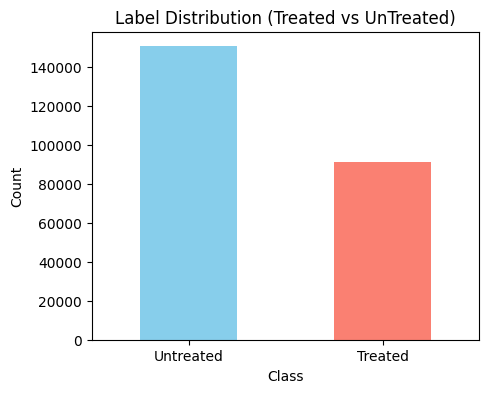

In [22]:
plt.figure(figsize=(5,4))
dataset["Treatment_Status"].value_counts().plot(
    kind="bar",
    color=["skyblue", "salmon"]
)
plt.title("Label Distribution (Treated vs UnTreated)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.show()

# Classification Problem (Treated vs Untreated Cells)

## Dataset Definition

In [23]:
X = dataset.drop(columns=["Treatment_Status","Subject_ID","treatment_encoded"])
y = dataset["treatment_encoded"]
feature_names = X.columns.tolist()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Classic Pipeline

In [25]:
# Standardization Dataset
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

In [26]:
# Train Randomforest Classifier
rf = RandomForestClassifier(
   n_estimators=300, 
   random_state=42, 
   max_depth=8, 
   min_samples_split=20, 
   min_samples_leaf=10,
   n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,8
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
# Accuracy Calculation
pred = rf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, pred))

Accuracy: 0.6324334372998988


In [28]:
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77     30119
           1       0.87      0.03      0.06     18294

    accuracy                           0.63     48413
   macro avg       0.75      0.51      0.42     48413
weighted avg       0.72      0.63      0.50     48413



## SHAP Analysis

In [29]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

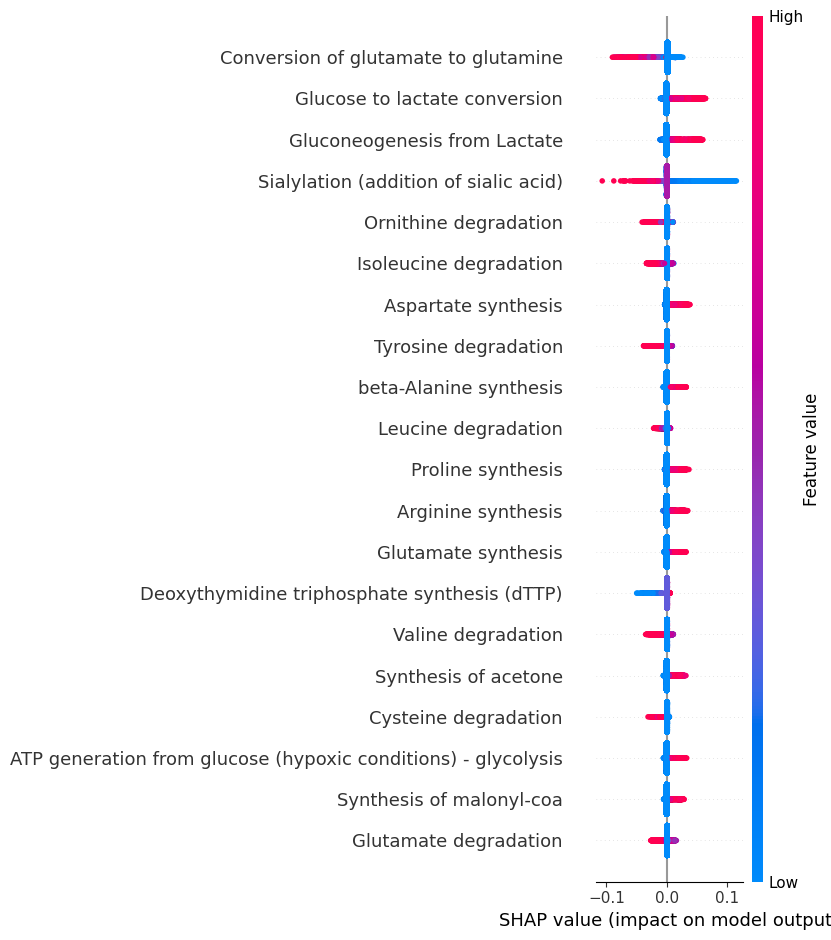

In [30]:
sv_class1 = shap_values[:, :, 1]
shap.summary_plot(sv_class1, features=X_test_scaled, feature_names=feature_names)

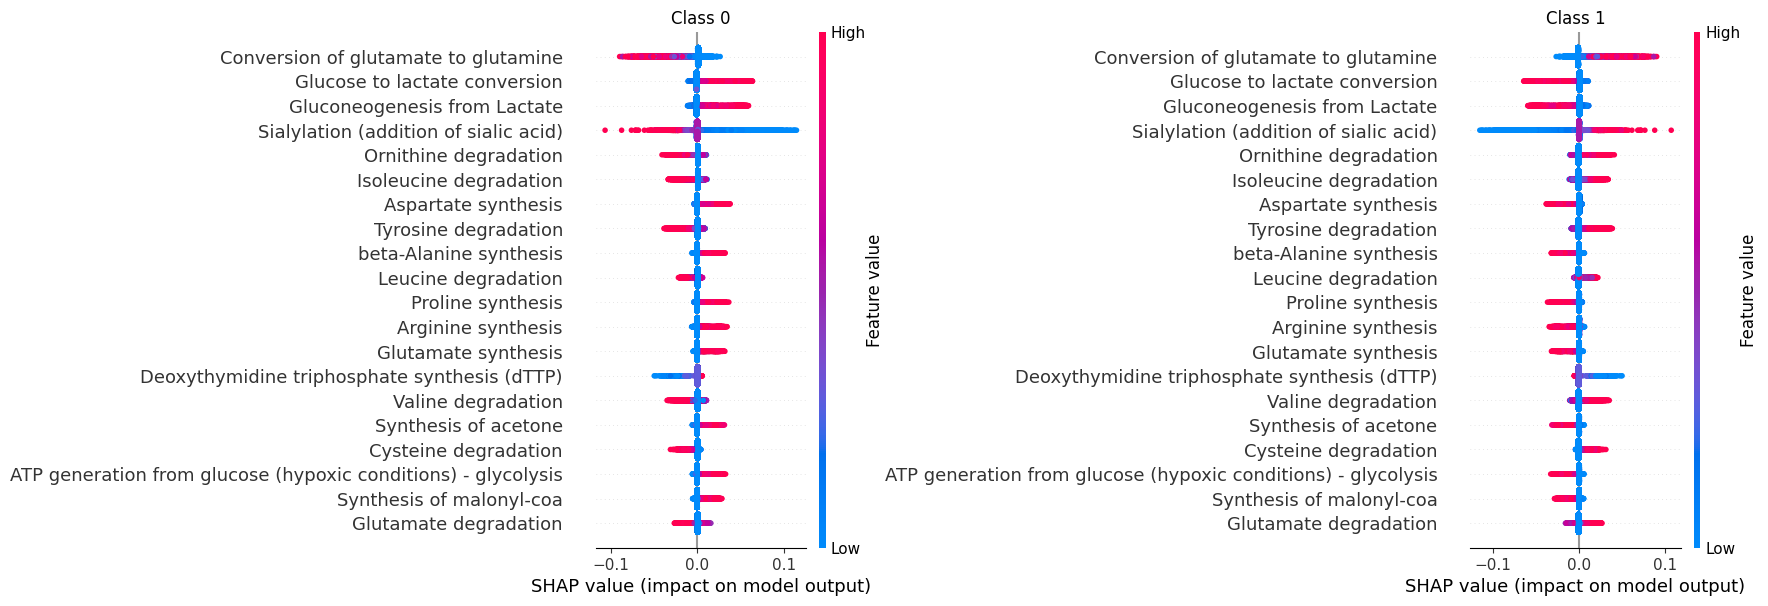

In [31]:
# Plot both of them
fig, axes = plt.subplots(1, shap_values.shape[2], figsize=(12, 6))

for c in range(shap_values.shape[2]):
    shap.summary_plot(
        shap_values[:, :, c], 
        features=X_test_scaled, 
        feature_names=feature_names, 
        show=False,  
        plot_size=None
    )
    plt.sca(axes[c])
    plt.title(f"Class {c}")

plt.tight_layout()
plt.show()

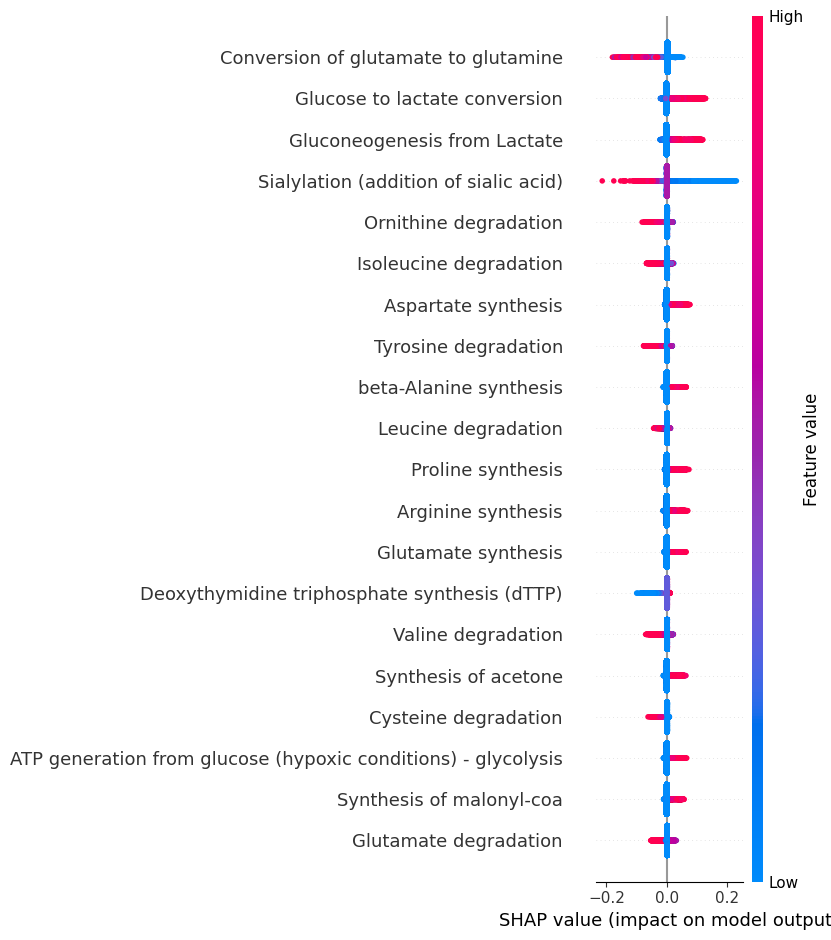

In [32]:
# shap diff plot
shap_diff = shap_values[:, :, 1] - shap_values[:, :, 0]
shap.summary_plot(
    shap_diff, 
    features=X_test_scaled, 
    feature_names=feature_names
)

In [33]:
# Feature importance via mean(|SHAP|)
mean_abs_shap = np.abs(shap_values[:,:,1]).mean(axis=0)
fi = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)
print("\nTop features by mean(|SHAP|):\n", fi.head(10))


Top features by mean(|SHAP|):
 Conversion of glutamate to glutamine     0.002129
Glucose to lactate conversion            0.001658
Gluconeogenesis from Lactate             0.001591
Sialylation (addition of sialic acid)    0.001474
Ornithine degradation                    0.000902
Isoleucine degradation                   0.000879
Aspartate synthesis                      0.000845
Tyrosine degradation                     0.000765
beta-Alanine synthesis                   0.000757
Leucine degradation                      0.000732
dtype: float64


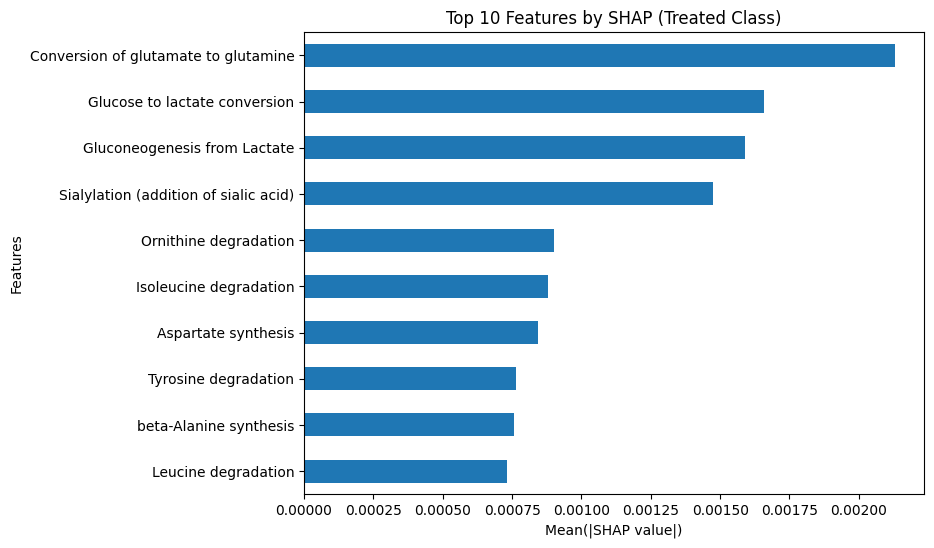

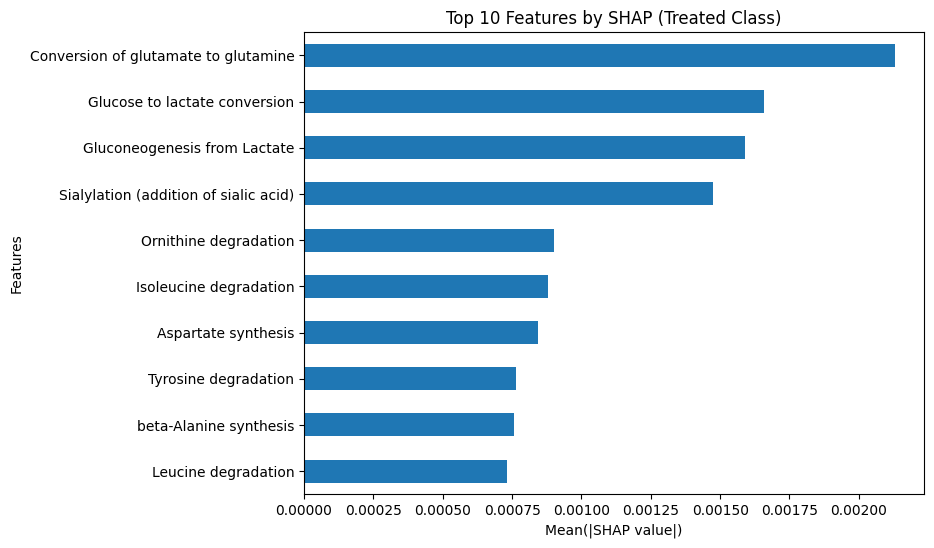

In [34]:
n_classes = shap_values.shape[2]

for c in range(n_classes):
    mean_abs_shap = np.abs(shap_values[:, :, c]).mean(axis=0)
    fi = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    fi.head(10).plot(kind='barh')
    plt.xlabel("Mean(|SHAP value|)")
    plt.ylabel("Features")
    # plt.title(f"Top 10 Features by SHAP (Class {c})")
    plt.title(f"Top 10 Features by SHAP (Treated Class)")
    plt.gca().invert_yaxis()
    plt.show()

# Modern Pipeline

### Preprocessing

In [ ]:
# define numerical and categorical feature title
# num_features = [col for col in X.columns if col.startswith("M")]
num_features = X.columns
# cat_features = ["Subject_ID"]

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        # ("cat", categorical_transformer, cat_features)
    ])

### Define Classifier Pipeline with Preprocessor

In [ ]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=42, max_depth=8, min_samples_split=20, min_samples_leaf=10))
    # ("classifier", LogisticRegression(max_iter=1000))
])

In [ ]:
clf.fit(X_train, y_train)

### Processed X data

In [ ]:
Xt = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
# Xt_df = pd.DataFrame(Xt.toarray(), columns=list(feature_names))
Xt_df = pd.DataFrame(Xt, columns=list(feature_names))
Xt_df

In [ ]:
# for col in [c for c in Xt_df.columns if c.startswith("num")]:
#     sns.boxplot(x=y_train, y=col, data=Xt_df)
#     plt.title(f"{col} by Treatment")
#     plt.show()

### Feature Importance

In [ ]:
# Mutual Information (non-linear relationships)
mi = mutual_info_classif(Xt_df, y_train, discrete_features='auto')
mi_series = pd.Series(mi, index=Xt_df.columns).sort_values(ascending=False)
mi_series

In [ ]:
# Feature importance from a model
importances = pd.Series(clf['classifier'].feature_importances_, index=Xt_df.columns).sort_values(ascending=False)
importances

In [ ]:
# Pearson / Point-biserial correlation (continuous features vs binary target)
corr = Xt_df.corrwith(y_train)
corr.sort_values()

### Model Evaluation

In [ ]:
y_pred = clf.predict(X_test)
classification_report(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()